# Example

This package allows defining your inference problem with:

* the [PyMC](https://docs.pymc.io/) probabilistic programming language
* by coding up the posterior by-hand and using [Jax](https://jax.readthedocs.io/) to automatically compute the necessary posterior gradients
* by specifying the posterior and its gradients completely by-hand

We'll start with PyMC, since it is the easiest. First, load up the relevant packages:

In [1]:
%pylab inline
from scipy import stats
import pymc as pm
from ttictoc import tic, toc
from muse_inference.pymc import PyMCMuseProblem

Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 110}
%load_ext autoreload
%autoreload 2
import logging, warnings
logging.getLogger("pymc").setLevel(logging.FATAL)
warnings.filterwarnings("ignore")

As an example, consider the following hierarchical problem, which has the classic [Neal's Funnel](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html) problem embedded in it. Neal's funnel is a standard example of a non-Gaussian latent space which HMC struggles to sample efficiently without extra tricks. Specifically, we consider the model defined by:

$$
\begin{aligned}
\theta &\sim {\rm Normal(0,3)} \\ 
z_i &\sim {\rm Normal}(0,\exp(\theta/2)) \\ 
x_i &\sim {\rm Normal}(z_i, 1)
\end{aligned}
$$

for $i=1..10000$. This problem can be described by the following PyMC model:

In [3]:
def gen_funnel(x=None, θ=None, rng=None):
    with pm.Model() as funnel:
        θ = pm.Normal("θ", mu=0, sigma=3) if θ is None else θ
        z = pm.Normal("z", mu=0, sigma=np.exp(θ/2), size=10000)
        x = pm.Normal("x", mu=z, sigma=1, observed=x)
    return funnel

Next, lets choose a true value of $\theta=0$ and generate some simulated data, $x$, which we'll use as "observations":

In [4]:
rng = np.random.RandomState(0)
with gen_funnel(θ=0):
    x_obs = pm.sample_prior_predictive(1, random_seed=0).prior.x[0,0]
model = gen_funnel(x=x_obs, rng=rng)

In [5]:
# warmup so timing results are more fair
with model:
    pm.sample(10, tune=10, cores=1, chains=1, discard_tuned_samples=False, random_seed=0, progressbar=False)
    pm.fit(10, method="advi", obj_n_mc=10, tf_n_mc=10, progressbar=False)
prob = PyMCMuseProblem(model)
result = prob.solve(θ_start=0, nsims=10, maxsteps=2)

We can run HMC on the problem to compute the "true" answer to compare against:

In [6]:
with model:
    tic()
    np.random.seed(1)
    chain = pm.sample(500, tune=500, chains=1, discard_tuned_samples=False)
    t_hmc = toc()

We next compute the MUSE estimate for the same problem. To reach the same Monte Carlo error as HMC, the number of MUSE simulations should be the same as the effective sample size of the chain we just ran. This is:

In [7]:
nsims = int(pm.ess(chain)["θ"])
nsims

59

Running the MUSE estimate, 

In [8]:
prob = PyMCMuseProblem(model)
rng = np.random.SeedSequence(1)
tic()
result = prob.solve(θ_start=0, nsims=nsims, rng=rng, progress=True, save_MAP_history=True)
t_muse = toc()

MUSE:   0%|          | 0/3000 [00:00<?, ?it/s]

MUSE:   0%|          | 7/3000 [00:00<00:46, 64.65it/s]

MUSE:   0%|          | 14/3000 [00:00<01:31, 32.66it/s]

MUSE:   1%|          | 21/3000 [00:00<01:09, 42.59it/s]

MUSE:   1%|          | 27/3000 [00:00<01:29, 33.18it/s]

MUSE:   1%|          | 34/3000 [00:00<01:13, 40.25it/s]

MUSE:   1%|▏         | 40/3000 [00:00<01:07, 44.00it/s]

MUSE:   2%|▏         | 46/3000 [00:01<01:22, 35.78it/s]

MUSE:   2%|▏         | 53/3000 [00:01<01:09, 42.33it/s]

MUSE:   2%|▏         | 60/3000 [00:01<01:01, 47.86it/s]

MUSE:   2%|▏         | 66/3000 [00:01<01:26, 34.06it/s]

MUSE:   2%|▏         | 73/3000 [00:01<01:12, 40.18it/s]

MUSE:   3%|▎         | 80/3000 [00:02<01:27, 33.48it/s]

MUSE:   3%|▎         | 87/3000 [00:02<01:14, 39.32it/s]

MUSE:   3%|▎         | 94/3000 [00:02<01:05, 44.66it/s]

MUSE:   3%|▎         | 101/3000 [00:02<01:19, 36.60it/s]

MUSE:   4%|▎         | 108/3000 [00:02<01:09, 41.72it/s]

MUSE:   4%|▍         | 115/3000 [00:02<01:01, 46.65it/s]

MUSE:   4%|▍         | 121/3000 [00:03<01:29, 32.05it/s]

MUSE:   4%|▍         | 128/3000 [00:03<01:15, 37.80it/s]

MUSE:   4%|▍         | 134/3000 [00:03<01:31, 31.37it/s]

MUSE:   5%|▍         | 141/3000 [00:03<01:16, 37.29it/s]

MUSE:   5%|▍         | 148/3000 [00:03<01:06, 42.75it/s]

MUSE:   5%|▌         | 154/3000 [00:04<01:21, 34.73it/s]

MUSE:   5%|▌         | 161/3000 [00:04<01:08, 41.20it/s]

MUSE:   6%|▌         | 168/3000 [00:04<01:00, 46.80it/s]

MUSE:   6%|▌         | 174/3000 [00:04<01:17, 36.37it/s]

MUSE: 100%|██████████| 3000/3000 [00:04<00:00, 4997.25it/s]

MUSE: 100%|██████████| 3000/3000 [00:04<00:00, 643.37it/s] 

get_H:   0%|          | 0/15 [00:00<?, ?it/s]

get_H:  47%|████▋     | 7/15 [00:00<00:00, 62.39it/s]

get_H:  93%|█████████▎| 14/15 [00:00<00:00, 33.45it/s]

get_H: 100%|██████████| 15/15 [00:00<00:00, 36.76it/s]

Lets also try mean-field variational inference (MFVI) to compare to another approximate method.

In [9]:
with model:
    tic()
    mfvi = pm.fit(10000, method="advi", obj_n_mc=10, tf_n_mc=10)
    t_mfvi = toc()

Now lets plot the different estimates. In this case, MUSE gives a nearly perfect answer using only a fraction posterior gradient calls. MFVI struggles in both speed and accuracy by comparison.

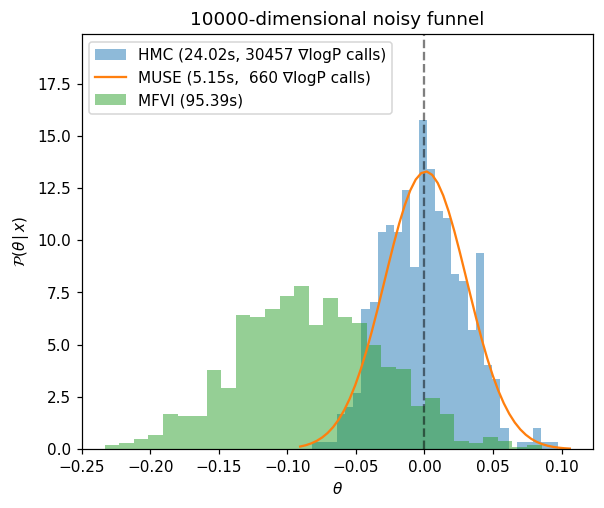

In [10]:
figure(figsize=(6,5))
axvline(0, c="k", ls="--", alpha=0.5)
ncalls_hmc = sum(chain.sample_stats["n_steps"]) + sum(chain.warmup_sample_stats["n_steps"])
hist(
    chain["posterior"]["θ"].to_series(), 
    bins=30, density=True, alpha=0.5, color="C0",
    label="HMC (%.2fs, %i ∇logP calls)"%(t_hmc, ncalls_hmc)
)
θs = linspace(*xlim())
ncalls_muse = sum(
    [s.nfev for h in result.history for s in [h["MAP_history_dat"]]+h["MAP_history_sims"]]
)
plot(
    θs, stats.norm(result.θ["θ"], sqrt(result.Σ[0,0])).pdf(θs), 
    color="C1", label="MUSE (%.2fs,  %i ∇logP calls)"%(t_muse, ncalls_muse)
)
hist(
    mfvi.sample(1000)["posterior"]["θ"].to_series(), 
    bins=30, density=True, alpha=0.5, color="C2",
    label="MFVI (%.2fs)"%t_mfvi
)
ylim(0, ylim()[1]*1.2)
legend(frameon=True)
xlabel(r"$\theta$")
ylabel(r"$\mathcal{P}(\theta\,|\,x)$")
title("10000-dimensional noisy funnel");

Note that due to PyMC overhead, the timing difference between HMC and MUSE is less drastic than the number of gradient calls would imply. For more realistic and expensive posterior functions, this overhead becomes negligible and you can see speedups of 10-100X or more (depending on problem and latent space dimensoinality). If you are working with small problems and need less overhead, the Jax or Numpy interfaces will be faster (or even consider using the Julia package [MuseInference.jl](https://cosmicmar.com/MuseInference.jl) which is the fastest of all options).